In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd
idx = pd.IndexSlice

In [3]:
import A2e
from mmctools.dataloaders import read_dir
from mmctools.helper_functions import covariance, power_law, fit_power_law_alpha

# MMC Perturbation Validation Study
Based on idealized **neutral** conditions observed at SWiFT between 2013-11-08 to 09

In [4]:
# DAP data
dataset = 'mmc/tower.z01.00'
datapath = 'data' # where the data will get saved locally
startdate = pd.to_datetime('2013-11-08 18:00')
enddate = pd.to_datetime('2013-11-09 02:00')

## 1. Data processing
### 1a. get data from DAP

In [5]:
a2e = A2e.A2e()
a2e.setup_cert_auth()

Certificate is setup
Valid certificate already created


True

In [6]:
datafiles = a2e.search({
    'Dataset': dataset,
    'date_time': {
        'between': [startdate.strftime('%Y%m%d%H%M%S'), enddate.strftime('%Y%m%d%H%M%S')]
    }
})
print(len(datafiles),'data files selected')

9 data files selected


In [7]:
%time filelist = a2e.download_files(datafiles,path=datapath)

File: data/mmc.tower.z01.00/tower.z01.00.20131108.180000.ttu200m.dat already exists, skipping...
File: data/mmc.tower.z01.00/tower.z01.00.20131108.200000.ttu200m.dat already exists, skipping...
File: data/mmc.tower.z01.00/tower.z01.00.20131108.220000.ttu200m.dat already exists, skipping...
File: data/mmc.tower.z01.00/tower.z01.00.20131108.210000.ttu200m.dat already exists, skipping...
File: data/mmc.tower.z01.00/tower.z01.00.20131108.190000.ttu200m.dat already exists, skipping...
File: data/mmc.tower.z01.00/tower.z01.00.20131108.230000.ttu200m.dat already exists, skipping...
File: data/mmc.tower.z01.00/tower.z01.00.20131109.000000.ttu200m.dat already exists, skipping...
File: data/mmc.tower.z01.00/tower.z01.00.20131109.010000.ttu200m.dat already exists, skipping...
File: data/mmc.tower.z01.00/tower.z01.00.20131109.020000.ttu200m.dat already exists, skipping...
CPU times: user 35.2 ms, sys: 5.31 ms, total: 40.6 ms
Wall time: 4.11 s


### 1b. process downloaded data

In [8]:
variables = ['unorth','vwest','w','ustream','vcross','wdir','tsonic','t','p','rh']
#heights_ft = [3,8,13,33,55,155,245,382,519,656]
heights = np.array([0.9, 2.4, 4.0, 10.1, 16.8, 47.3, 74.7, 116.5, 158.2, 200.0])
sampling_freq = 50. # Hz

In [9]:
columns = pd.MultiIndex.from_product([heights,variables],names=['height',None]) # variables change the fastest, then heights
def read_wide_csv(fname,reindex=False):
    """Convert table in wide format into stacked/long format with multiindex
    If 'reindex' is True, then reindex the resulting dataframe to conform to 
    a DateTimeIndex with regular intervals as dictated by 'sampling_freq'.
    """
    df = pd.read_csv(fname,
                     skiprows=5, header=None,
                     index_col=0, parse_dates=True)
    df.index.name = 'datetime'
    df.columns = columns
    if reindex:
        ms = int(1000/sampling_freq)
        tindex = pd.date_range(start=df.index[0],
                               end=df.index[-1],
                               freq='{:d}ms'.format(ms))
        df = df.reindex(index=tindex)
    return df.stack(level=0)

In [10]:
%time rawdata = pd.concat([ read_wide_csv(fname) for fname in sorted(filelist) ])
rawdata.head()

CPU times: user 1min 25s, sys: 15.2 s, total: 1min 40s
Wall time: 58.7 s


p      rh        t  tsonic    unorth  \
datetime            height                                                 
2013-11-08 18:00:00 0.9     90.241160  28.262  58.1180  65.804 -6.850388   
                    2.4     90.273568  28.630  57.5420  67.640 -6.666100   
                    4.0     90.212748  28.590  57.6464  60.908 -5.628619   
                    10.1    90.147153  29.418  56.6024  60.152 -7.572664   
                    16.8    90.123550  30.098  56.2028  60.818 -7.628899   

                             ustream    vcross     vwest         w        wdir  
datetime            height                                                      
2013-11-08 18:00:00 0.9     7.056404  0.196796  1.704040 -0.371554  193.968860  
                    2.4     6.700411  0.869080  1.101779 -0.572384  189.385054  
                    4.0     5.580902  1.025209  0.718449  0.705058  187.274022  
                    10.1    7.545095  1.193652  1.004009  1.525222  187.552419  
                    16.8    7.386952  2.053941  0.765259  0.482372  185.728209

In [11]:
rawdata['u'] = rawdata['vwest']
rawdata['v'] = -rawdata['unorth']
rawdata['wspd'] = np.sqrt(rawdata['u']**2 + rawdata['v']**2)

<font color='red'>for tower.z01.00 only</font>

In [12]:
# convert from deg F to K
rawdata['t'] = 5./9. * (rawdata['t']-32) + 273.15
rawdata['tsonic'] = 5./9. * (rawdata['tsonic']-32) + 273.15

In [13]:
# convert kPa to mbar
rawdata['p'] *= 10.

expected dataframe format:

In [14]:
rawdata

p        rh           t      tsonic  \
datetime                height                                                 
2013-11-08 18:00:00.000 0.9     902.411597  28.26200  287.660000  291.930000   
                        2.4     902.735676  28.63000  287.340000  292.950000   
                        4.0     902.127478  28.59000  287.398000  289.210000   
                        10.1    901.471532  29.41800  286.818000  288.790000   
                        16.8    901.235500  30.09800  286.596000  289.160000   
                        47.3    896.767484  30.64200  286.036000  289.600000   
                        74.7    894.515528  30.92200  285.860000  290.110000   
                        116.5   890.303524  32.15600  285.332000  286.100000   
                        158.2   886.019389  32.49800  284.940000  288.570000   
                        200.0   881.207653  33.36600  284.601994  286.960000   
2013-11-08 18:00:00.020 0.9     902.387554  28.27000  287.678000  291.959994   
                        2.4     902.703505  28.64200  287.380000  292.820000   
                        4.0     902.111562  28.60400  287.394000  289.200000   
                        10.1    901.467469  29.45800  286.830000  288.800000   
                        16.8    901.099706  30.07400  286.576000  289.170000   
                        47.3    896.771548  30.60800  286.036000  289.620000   
                        74.7    894.531444  30.91000  285.850000  290.230000   
                        116.5   890.447446  32.27200  285.432000  286.080000   
                        158.2   885.971641  32.51000  284.938000  288.640000   
                        200.0   881.127396  33.31600  284.530000  286.930000   
2013-11-08 18:00:00.040 0.9     902.423449  28.25600  287.700000  291.900000   
                        2.4     902.651693  28.63600  287.362000  292.810000   
                        4.0     902.087519  28.58800  287.370000  289.280000   
                        10.1    901.471532  29.45400  286.870000  288.880000   
                        16.8    901.107494  30.07800  286.546000  289.080000   
                        47.3    896.791528  30.62400  286.060000  289.550000   
                        74.7    894.607638  30.89400  285.868000  290.220000   
                        116.5   890.411550  32.19200  285.430000  286.100000   
                        158.2   886.011600  32.52400  284.960000  288.590000   
                        200.0   881.115543  33.31200  284.492000  286.800000   
...                                    ...       ...         ...         ...   
2013-11-09 02:59:58.840 16.8    897.511476  77.33600  280.706000  282.010000   
                        47.3    893.127443  79.33200  280.580000  284.810000   
                        74.7    890.811484  78.82600  280.638000  285.610000   
                        116.5   886.459621  81.24000  280.274000  281.640000   
                        158.2   882.171423  83.17400  280.244000  284.410000   
                        200.0   877.143635  82.97401  280.214000  283.680000   
2013-11-09 02:59:58.860 0.9     898.903625  79.30800  280.506000  284.920000   
                        2.4     899.203660  78.71200  280.556000  286.170000   
                        4.0     898.555503  77.34200  280.708000  282.960000   
                        10.1    897.967624  77.83400  280.772000  282.230000   
                        16.8    897.515540  77.33000  280.712000  282.010000   
                        47.3    893.383455  79.53400  280.708000  284.800000   
                        74.7    890.823675  78.87200  280.686000  285.640000   
                        116.5   886.459621  81.24000  280.294000  281.620000   
                        158.2   882.179550  83.22601  280.236000  284.420000   
                        200.0   877.131444  82.97600  280.196000  283.720000   
2013-11-09 02:59:58.880 0.9     898.895498  79.31200  280.494000  284.970000   
                        2.4     899.10342

In [15]:
expected_rows = int(len(heights)*len(filelist)*3600*sampling_freq)
print('data completeness: {:g}% ({:d}/{:d})'.format(100*len(rawdata)/expected_rows,
                                                    len(rawdata), expected_rows))

data completeness: 99.9935% (16198948/16200000)


## 2. Calculations
### 2a. basic statistics

In [16]:
stats = {}
unstacked = rawdata.unstack()

let's work with 1Hz data instead of 50Hz

In [17]:
unstacked = unstacked.resample('1s').first()

In [18]:
def calc_stats(offset,verbose=True):
    """Calculate statistics with specified pandas offset"""
    if verbose:
        'Calculating means'
    df = unstacked.rolling(offset).mean().stack()
    # TODO: general MMC calculations here
    df['wspd'] = np.sqrt(df['u']**2 + df['v']**2)
    # - recalculate wind direction
    if verbose:
        'Updating wind direction'
    newdir = np.degrees(np.arctan2(-df['u'],-df['v']))
    newdir[newdir < 0] += 360.0
    df['wdir'] = newdir
    # - calculate potential temperature
    df['theta'] = df['t'] * (1000./df['p'])**0.286
    # - calculate variances
    if verbose:
        'Calculating variances'
    df['uu'] = unstacked['u'].rolling(offset).var().stack()
    df['vv'] = unstacked['v'].rolling(offset).var().stack()
    df['ww'] = unstacked['w'].rolling(offset).var().stack()
    # - calculate covariances
    if verbose:
        'Calculating covariances'
    df['uv'] = covariance(unstacked[('u',)],unstacked[('v',)],offset).stack()
    df['vw'] = covariance(unstacked[('v',)],unstacked[('w',)],offset).stack()
    df['uw'] = covariance(unstacked[('u',)],unstacked[('w',)],offset).stack()
    df['tw'] = covariance(unstacked[('tsonic',)],unstacked[('w',)],offset).stack()
    # - calculate derived quantities
    if verbose:
        'Calculating additional turbulence quantities'
    df['u*'] = (df['uw']**2 + df['vw']**2)**0.25
    df['TKE'] = 0.5*(df['uu'] + df['vv'] + df['ww'])
    # TODO: compare this TI calc with unstacked.rolling(offset).std()/UHmag
    ang = np.radians(270. - df['wdir'])
    ang[ang<0] += 2*np.pi
    df['TI'] = df['uu']*np.cos(ang)**2 + 2*df['uv']*np.sin(ang)*np.cos(ang) + df['vv']**np.sin(ang)**2
    df['TI'] = np.sqrt(df['TI']) / df['wspd']
    return df

In [19]:
%time stats['10min'] = calc_stats('10min')

CPU times: user 7.99 s, sys: 1.75 s, total: 9.75 s
Wall time: 5.51 s


In [20]:
%time stats['15min'] = calc_stats('15min')

CPU times: user 8.09 s, sys: 1.82 s, total: 9.91 s
Wall time: 4.34 s


In [21]:
%time stats['1h'] = calc_stats('1h')

CPU times: user 7.95 s, sys: 1.83 s, total: 9.78 s
Wall time: 4.26 s


- verify: 1-Hz data (more computationally efficient) agrees with calculations from raw 50-Hz data

In [22]:
%%time
testheight = 74.7
offset = '10min'
test = rawdata.xs(testheight,level=1).sort_index()
df = test.rolling(offset).mean()
df['wspd'] = np.sqrt(df['u']**2 + df['v']**2)
newdir = np.degrees(np.arctan2(-df['u'],-df['v']))
newdir[newdir < 0] += 360.0
df['wdir'] = newdir
df['uu'] = test['u'].rolling(offset).var()
df['vv'] = test['v'].rolling(offset).var()
df['ww'] = test['w'].rolling(offset).var()
df['uv'] = covariance(test['u'],test['v'],offset)
df['vw'] = covariance(test['v'],test['w'],offset)
df['uw'] = covariance(test['u'],test['w'],offset)
df['tw'] = covariance(test['tsonic'],test['w'],offset)
df['u*'] = (df['uw']**2 + df['vw']**2)**0.25
df['TKE'] = 0.5*(df['uu'] + df['vv'] + df['ww'])
# TODO: compare this TI calc with unstacked.rolling(offset).std()/UHmag
ang = np.radians(270. - df['wdir'])
ang[ang<0] += 2*np.pi
df['TI'] = df['uu']*np.cos(ang)**2 + 2*df['uv']*np.sin(ang)*np.cos(ang) + df['vv']**np.sin(ang)**2
df['TI'] = np.sqrt(df['TI']) / df['wspd']
df50Hz = df.copy()

CPU times: user 15.1 s, sys: 9.64 s, total: 24.7 s
Wall time: 9.07 s


u rms err : 0.009767006538130086
v rms err : 0.00802404889523398
w rms err : 0.00960456651576642
wspd rms err : 0.0077709632773296546
wdir rms err : 0.05067087818320438
t rms err : 0.002244575422341142
tsonic rms err : 0.0034298316046783538
uu rms err : 0.017971278542614964
vv rms err : 0.016406150715597288
ww rms err : 0.014934259020430787
uv rms err : 0.012252994049405275
uw rms err : 0.011331383396436507
vw rms err : 0.009963550466894448
tw rms err : 0.5838131586886304
u* rms err : 0.0123459025266578
TKE rms err : 0.015168935743295432
TI rms err : 0.0006968394409511221


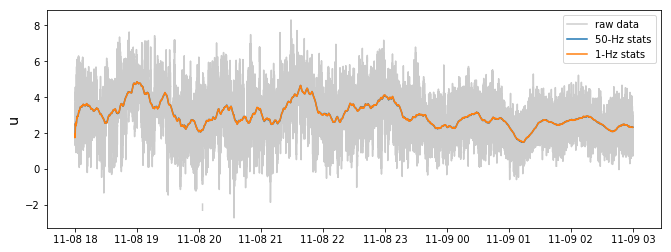

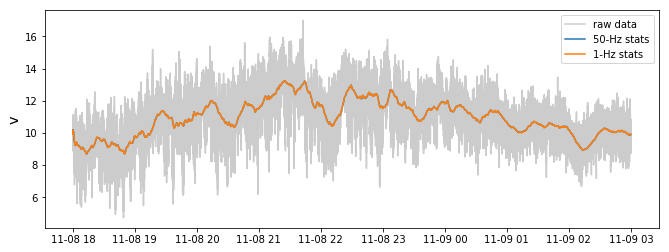

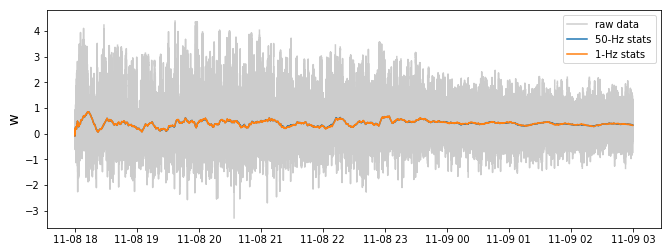

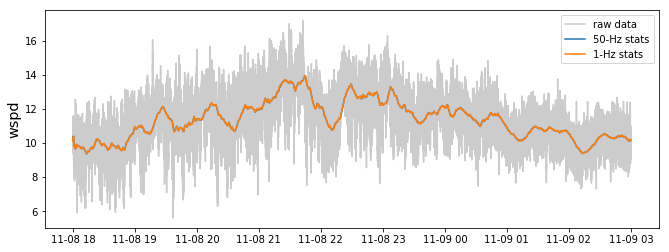

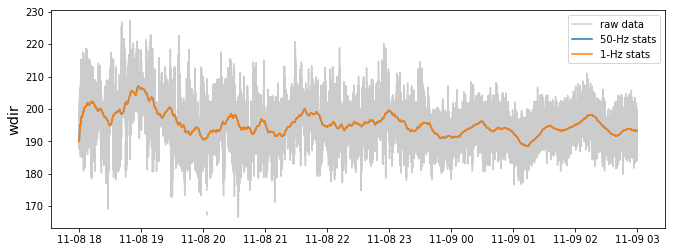

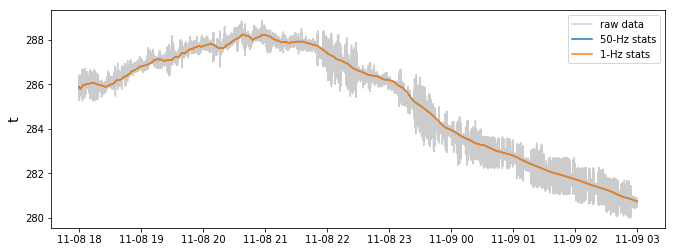

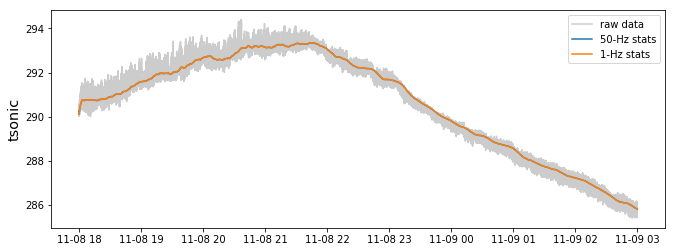

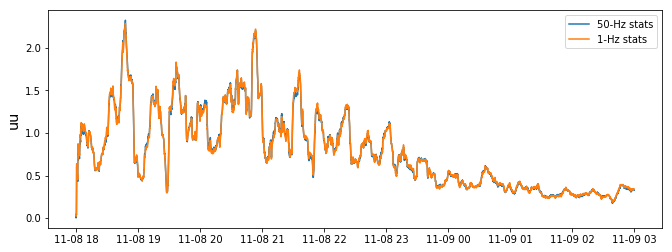

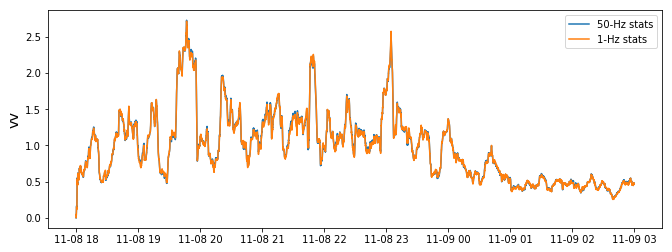

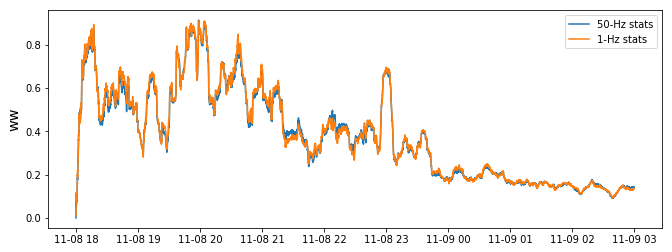

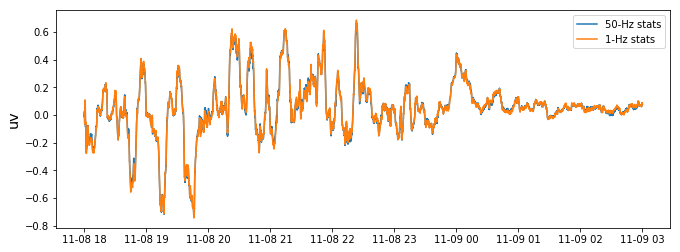

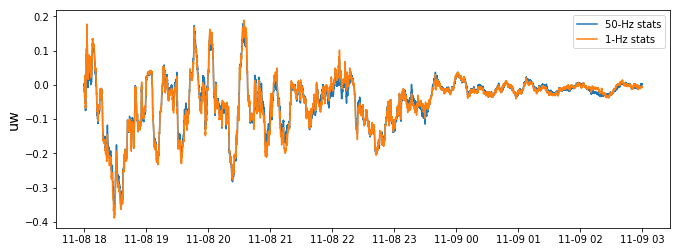

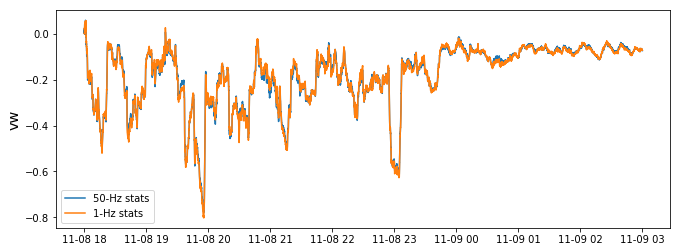

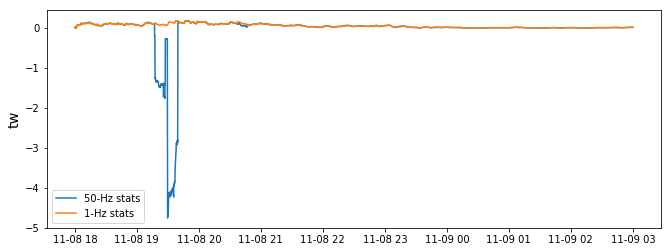

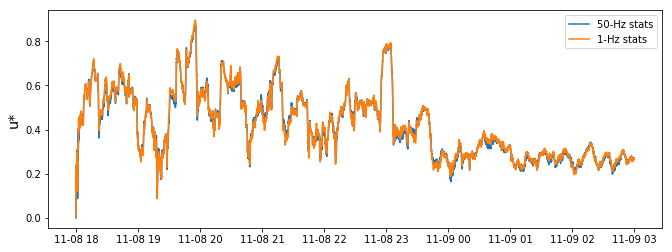

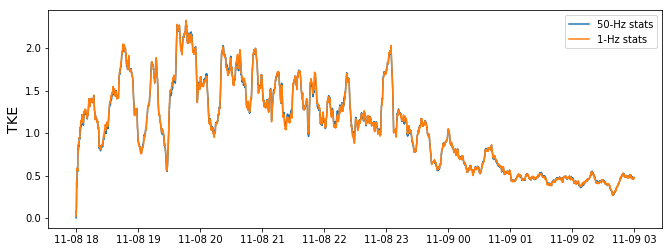

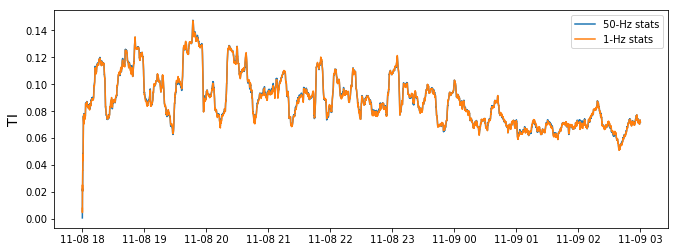

In [23]:
from_1Hz = stats['10min'].xs(testheight,level=1)
for plotvar in ['u','v','w','wspd','wdir',
                't','tsonic',
                'uu','vv','ww','uv','uw','vw','tw','u*','TKE','TI']:
    plt.figure(figsize=(11,4))
    try:
        plt.plot(test.index, test[plotvar], 'k-', alpha=0.2, label='raw data')
    except KeyError: pass
    plt.plot(df50Hz.index, df50Hz[plotvar], label='50-Hz stats')
    plt.plot(from_1Hz.index, from_1Hz[plotvar], label='1-Hz stats')
    plt.ylabel(plotvar,fontsize='x-large')
    plt.legend(loc='best')
    err = df50Hz.reindex(index=from_1Hz.index)[plotvar] - from_1Hz[plotvar]
    print(plotvar,'rms err :',np.sqrt(np.nanmean(err**2)))

Good agreement observed between 1-Hz and 50-Hz calculations in all quantities <font color='red'>_except_ for T'w'</font>. 

__To follow-up w/ Sandia (e.g., Brian Naughton):__ ``high-frequency sonic data may be unreliable''
- does this account for the large fluctuations in $T_s$?
- perhaps Branko's processed data (mmc/tower.z01.a0) will be better

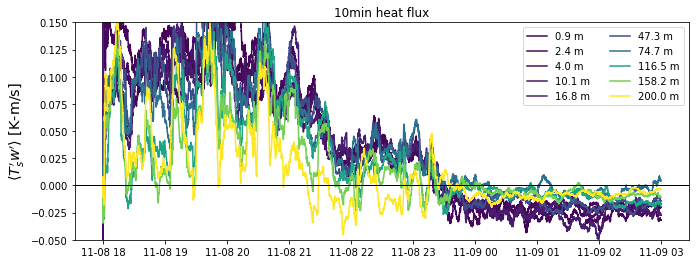

In [24]:
offset = '10min'
cmap = plt.get_cmap('viridis')

fig,ax = plt.subplots(figsize=(11,4))
for z in heights:
    zfrac = z/heights[-1]
    color = cmap(zfrac)
    ax.plot(stats[offset].index.levels[0], stats[offset]['tw'].xs(z,level=1),
            color=color,
            label='{:.1f} m'.format(z))
ax.axhline(0,color='k',lw=1)
ax.set_ylim((-0.05,0.15))
ax.set_ylabel(r"$\langle T_s' w' \rangle$ [K-m/s]", fontsize='x-large')
ax.set_title(offset+' heat flux')
ax.legend(ncol=2)

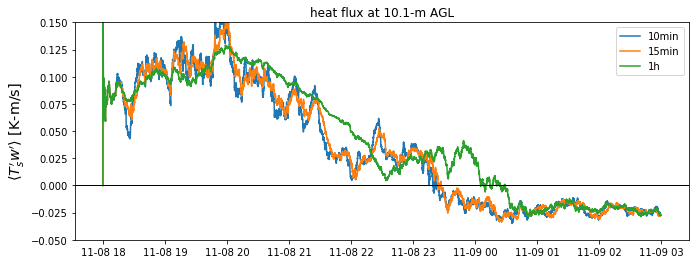

In [25]:
z = 10.1

fig,ax = plt.subplots(figsize=(11,4))
for offset,df in stats.items():
    ax.plot(df.index.levels[0], df['tw'].xs(z,level=1),
            label=offset)
ax.axhline(0,color='k',lw=1)
ax.set_ylim((-0.05,0.15))
ax.set_ylabel(r"$\langle T_s' w' \rangle$ [K-m/s]", fontsize='x-large')
ax.set_title('heat flux at {:.1f}-m AGL'.format(z))
ax.legend()

### 2b. estimate shear exponent

In [26]:
zref = 74.7
z = np.array(heights)

In [27]:
%%time
shear = {}
for offset,df in stats.items():
    #print(offset)
    wspd = df['wspd'].unstack()
    alpha,R2 = [],[]
    selected_times = pd.date_range(start=df.index.levels[0][0], end=df.index.levels[0][-1], freq=offset)
    for tstamp in selected_times:
        #print(tstamp)
        u = wspd.loc[tstamp]
        a,good = fit_power_law_alpha(z, u, zref=zref, Uref=u.loc[zref])
        alpha.append(a)
        R2.append(good)
    shear[offset] = pd.DataFrame(data=dict(alpha=alpha,R2=R2),index=selected_times)

CPU times: user 2.3 s, sys: 726 ms, total: 3.03 s
Wall time: 1.23 s


Text(0, 0.5, 'shear exponent [-]')

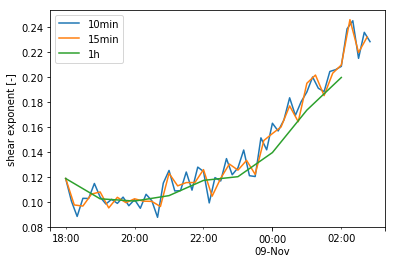

In [28]:
for offset,df in shear.items():
    df['alpha'].plot(label=offset)
plt.legend()
plt.ylabel('shear exponent [-]')

estimate mechanical production term

## 3. Presentation
### 3a. profile plots

In [29]:
offset = '15min'
cmap = get_cmap('rainbow')

In [30]:
startdate,enddate

(Timestamp('2013-11-08 18:00:00'), Timestamp('2013-11-09 02:00:00'))

Notes:
- statistics are recorded at the **right edge** of the interval
- statistics between 'startdate' and 'startdate' + 'offset' should be discarded, as the window size is inconsistent with the rest of the statistical data
- 'enddate' corresponds to the last datafile that was downloaded and processed, which includes data between 'enddate' and 'enddate' + 00:59... minutes

TODO:
- calculate rotated u'w', shear production term

In [31]:
df = stats[offset]

In [32]:
# only plot every 'offset'
selected_times = pd.date_range(start='2013-11-08 19:00', end='2013-11-09 02:00', freq=offset)

In [33]:
# for selecting colormap value
timefrac = (selected_times - selected_times[0]) / (selected_times[-1] - selected_times[0])

### mean profiles

(0, 210)

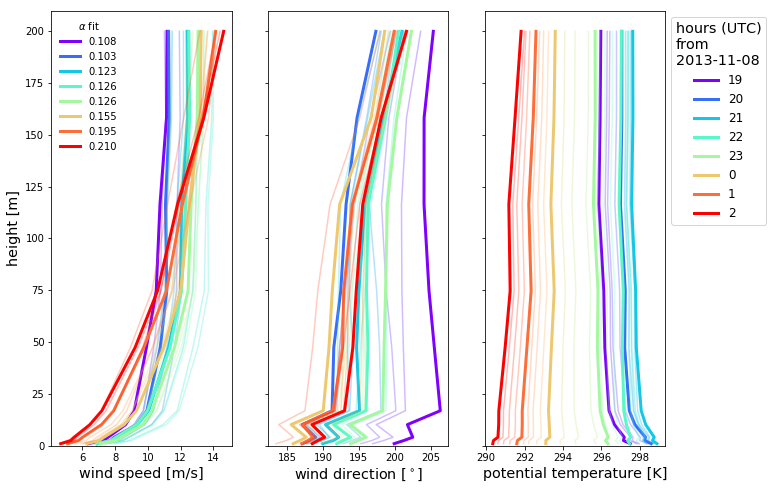

In [34]:
fig,ax = plt.subplots(ncols=3,sharey=True,figsize=(11,8))
alpha = shear[offset]['alpha']
for snapshot,color in zip(selected_times,cmap(timefrac)):
    onthehour = (snapshot.minute == 0)
    #print(snapshot,onthehour)
    profiles = df.loc[snapshot]
    if onthehour:
        ax[0].plot(profiles['wspd'],heights,color=color,lw=3,label='{:.3f}'.format(alpha.loc[snapshot]))
        ax[1].plot(profiles['wdir'],heights,color=color,lw=3)
        ax[2].plot(profiles['theta'],heights,color=color,lw=3,label=snapshot.hour)
    else:
        ax[0].plot(profiles['wspd'],heights,color=color,alpha=0.3)
        ax[1].plot(profiles['wdir'],heights,color=color,alpha=0.3)
        ax[2].plot(profiles['theta'],heights,color=color,alpha=0.3)
ax[0].set_ylabel('height [m]',fontsize='x-large')
ax[0].set_xlabel('wind speed [m/s]',fontsize='x-large')
ax[1].set_xlabel(r'wind direction [$^\circ$]',fontsize='x-large')
ax[2].set_xlabel('potential temperature [K]',fontsize='x-large')
ax[0].legend(frameon=False,title=r'$\alpha$ fit')
leg = ax[-1].legend(loc='upper left',bbox_to_anchor=(1,1),fontsize='large')
leg.set_title(title='hours (UTC)\nfrom\n{:s}'.format(str(startdate.date())),
              prop=dict(size='x-large'))
ax[-1].set_ylim((0,210))

(0, 210)

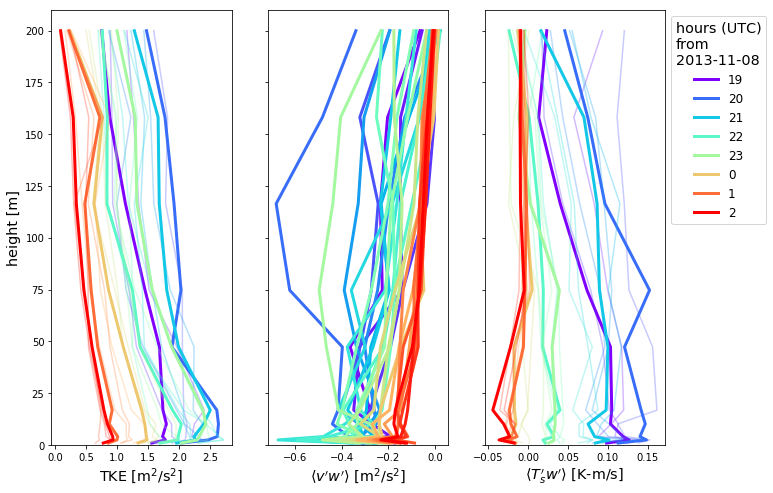

In [35]:
fig,ax = plt.subplots(ncols=3,sharey=True,figsize=(11,8))
for snapshot,color in zip(selected_times,cmap(timefrac)):
    onthehour = (snapshot.minute == 0)
    #print(snapshot,onthehour)
    profiles = df.loc[snapshot]
#     production = shear_production[offset].loc[snapshot]
    if onthehour:
        ax[0].plot(profiles['TKE'],heights,color=color,lw=3)
#         ax[1].plot(production,heights,color=color,lw=3)
        ax[1].plot(profiles['vw'],heights,color=color,lw=3)
        ax[2].plot(profiles['tw'],heights,color=color,lw=3,label=snapshot.hour)
    else:
        ax[0].plot(profiles['TKE'],heights,color=color,alpha=0.3)
#         ax[1].plot(production,heights,color=color,alpha=0.3)
        ax[1].plot(profiles['vw'],heights,color=color,lw=3)
        ax[2].plot(profiles['tw'],heights,color=color,alpha=0.3)
ax[0].set_ylabel('height [m]',fontsize='x-large')
ax[0].set_xlabel(r'TKE [m$^2$/s$^2$]',fontsize='x-large')
#ax[1].set_xlabel(r"$\langle u'w' \rangle$ dU/dz [m$^2$/s$^3$]",fontsize='x-large')
ax[1].set_xlabel(r"$\langle v'w' \rangle$ [m$^2$/s$^2$]",fontsize='x-large')
ax[2].set_xlabel(r"$\langle T_s'w' \rangle$ [K-m/s]",fontsize='x-large')
leg = ax[-1].legend(loc='upper left',bbox_to_anchor=(1,1),fontsize='large')
leg.set_title(title='hours (UTC)\nfrom\n{:s}'.format(str(startdate.date())),
              prop=dict(size='x-large'))
ax[-1].set_ylim((0,210))

## inflow estimates

In [36]:
df

p         rh           t      tsonic  \
datetime            height                                                  
2013-11-08 18:00:00 0.9     902.411597  28.262000  287.660000  291.930000   
                    2.4     902.735676  28.630000  287.340000  292.950000   
                    4.0     902.127478  28.590000  287.398000  289.210000   
                    10.1    901.471532  29.418000  286.818000  288.790000   
                    16.8    901.235500  30.098000  286.596000  289.160000   
                    47.3    896.767484  30.642000  286.036000  289.600000   
                    74.7    894.515528  30.922000  285.860000  290.110000   
                    116.5   890.303524  32.156000  285.332000  286.100000   
                    158.2   886.019389  32.498000  284.940000  288.570000   
                    200.0   881.207653  33.366000  284.601994  286.960000   
2013-11-08 18:00:01 0.9     902.433609  28.269000  287.680000  291.940000   
                    2.4     902.701642  28.649000  287.335000  293.170000   
                    4.0     902.153553  28.639000  287.422000  289.355000   
                    10.1    901.515556  29.407000  286.830000  288.510000   
                    16.8    901.191477  30.091000  286.565000  288.755000   
                    47.3    896.755462  30.628000  286.036000  289.774997   
                    74.7    894.529582  30.915000  285.864000  290.170000   
                    116.5   890.263564  32.162000  285.339000  286.160000   
                    158.2   886.033443  32.519000  284.947000  288.485000   
                    200.0   881.155503  33.360000  284.555997  286.960000   
2013-11-08 18:00:02 0.9     902.412952  28.273333  287.678667  292.016667   
                    2.4     902.647629  28.638667  287.320000  293.170000   
                    4.0     902.118222  28.628000  287.432000  289.439998   
                    10.1    901.496930  29.424000  286.845333  288.566667   
                    16.8    901.171497  30.084667  286.568000  288.656667   
                    47.3    896.764775  30.618000  286.034000  289.713331   
                    74.7    894.555601  30.916667  285.872667  290.193333   
                    116.5   890.248890  32.134667  285.317333  286.146667   
                    158.2   886.034176  32.526000  284.959333  288.513333   
                    200.0   881.126154  33.342000  284.526665  286.960000   
...                                ...        ...         ...         ...   
2013-11-09 02:59:56 0.9     898.904979  78.600671  280.602554  285.113333   
                    2.4     899.117257  78.063109  280.647213  286.299644   
                    4.0     898.583558  76.697107  280.831017  283.116411   
                    10.1    897.968480  77.152287  280.824800  282.332111   
                    16.8    897.603709  76.588742  280.794762  282.215200   
                    47.3    893.206018  78.640469  280.710900  284.685011   
                    74.7    890.883568  78.219833  280.780955  285.896100   
                    116.5   886.454582  80.473149  280.353096  281.760033   
                    158.2   882.160171  82.425949  280.346887  284.633456   
                    200.0   877.206208  82.508265  280.257818  283.723622   
2013-11-09 02:59:57 0.9     898.904953  78.602173  280.602365  285.113067   
                    2.4     899.117235  78.064593  280.647002  286.299467   
                    4.0     898.583522  76.698429  280.830769  283.116356   
                    10.1    897.968355  77.153669  280.824568  282.332011   
                    16.8    897.603683  76.590236  280.794537  282.215433   
                    47.3    893.205947  78.642093  280.710664  284.684767   
                    74.7    890.883559  78.221311  280.780666  285.895933   
                    116.5   886.454618  80.474889  280.352920  281.759167   
                    158.2   882.160220  82.427711  280.346640  284.633300   
                    200.0   877.2

In [37]:
# calculate hub height ("hh") quantities
zhub = 90.
zbelow = heights[heights < zhub][-1]
zabove = heights[heights > zhub][0]
above = df.xs(zabove,level=1)
below = df.xs(zbelow,level=1)
hh = (zhub-zbelow)/(zabove-zbelow)*(above-below) + below

In [38]:
# hub-height data are at 1 Hz
assert (hh.index[1] - hh.index[0]).components.seconds == 1

In [39]:
def get_conditions(t0,t1):
    t0 = pd.to_datetime(t0)
    t1 = pd.to_datetime(t1)
    print(str(t0),'to',str(t1))
    print('------------------------------------------')
    print(t1-t0)
    # 1-Hz
    print('Umean(zhub) = {:g} m/s'.format(hh.loc[(hh.index >= t0) & (hh.index <= t1),'wspd'].mean()))
    print('TI(zhub) = {:g}%'.format(100*hh.loc[(hh.index >= t0) & (hh.index <= t1),'TI'].mean()))
    # 'offset' output frequency, at _right_ of interval (note the different left/right bounds)
    print('alpha = {:g}'.format(alpha[(alpha.index > t0) & (alpha.index <= t1)].mean()))    

In [40]:
get_conditions('2013-11-08 20:00', '2013-11-08 22:00')

2013-11-08 20:00:00 to 2013-11-08 22:00:00
------------------------------------------
0 days 02:00:00
Umean(zhub) = 12.3341 m/s
TI(zhub) = 9.37092%
alpha = 0.111318


In [41]:
get_conditions('2013-11-08 22:00', '2013-11-08 23:00')

2013-11-08 22:00:00 to 2013-11-08 23:00:00
------------------------------------------
0 days 01:00:00
Umean(zhub) = 12.3547 m/s
TI(zhub) = 8.96891%
alpha = 0.119911


In [42]:
get_conditions('2013-11-08 23:00', '2013-11-09 00:00')

2013-11-08 23:00:00 to 2013-11-09 00:00:00
------------------------------------------
0 days 01:00:00
Umean(zhub) = 12.1187 m/s
TI(zhub) = 8.62227%
alpha = 0.139905


In [43]:
get_conditions('2013-11-09 00:00', '2013-11-09 01:00')

2013-11-09 00:00:00 to 2013-11-09 01:00:00
------------------------------------------
0 days 01:00:00
Umean(zhub) = 11.9098 m/s
TI(zhub) = 7.46082%
alpha = 0.174168
